# Import the Libraries

In [43]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from tqdm import tqdm

# Training the GAN

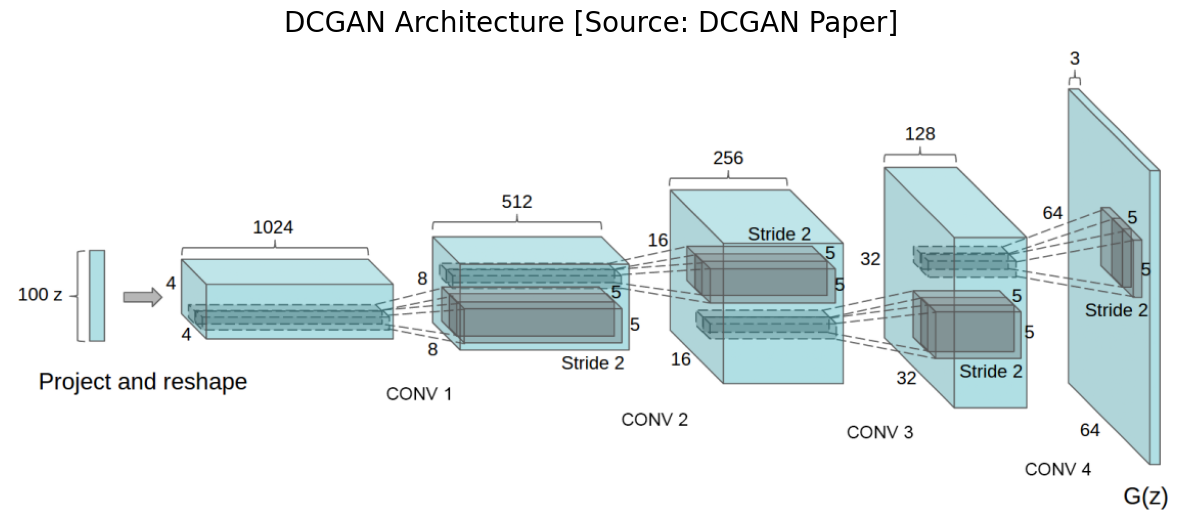

In [44]:
plt.figure(figsize=(15, 8));
plt.imshow(plt.imread("DCGAN_Arch.png"));
plt.axis('off');
plt.title("DCGAN Architecture [Source: DCGAN Paper]", fontsize=20);

## Models Architecture

In [45]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d, num_classes):
        super().__init__()
        self.disc = nn.Sequential(
            # Input: N x channels_img + num_classes x 64 x 64 (we added num_classes more channels for the one-hot encoded label)
            nn.Conv2d(
                channels_img + num_classes, features_d, kernel_size=4, stride=2, padding=1
            ),
            # 32 x 32
            nn.LeakyReLU(0.2),
            # no batch norm on first layer
            self._block(features_d, features_d*2, 4, 2, 1), # (32x32 -> 16x16)
            self._block(features_d*2, features_d*4, 4, 2, 1), # (16x16 -> 8x8)
            self._block(features_d*4, features_d*8, 4, 2, 1), # (8x8 -> 4x4)
            nn.Conv2d(features_d*8, 1, kernel_size=4, stride=2, padding=0), # (4x4 -> 1x1)
            nn.Sigmoid(),
        )


    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False, # batch norm handles bias
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

In [46]:
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g, num_classes):
        super().__init__()
        self.gen = nn.Sequential(
            # Input: N x z_dim + num_classes x 1 x 1 (we added num_classes more channels for the one-hot encoded label)
            self._block(z_dim + num_classes, features_g*16, 4, 1, 0), # (1x1 -> 4x4)
            self._block(features_g*16, features_g*8, 4, 2, 1), # (4x4 -> 8x8)
            self._block(features_g*8, features_g*4, 4, 2, 1), # (8x8 -> 16x16)
            self._block(features_g*4, features_g*2, 4, 2, 1), # (16x16 -> 32x32)
            nn.ConvTranspose2d(
                features_g*2, channels_img, kernel_size=4, stride=2, padding=1
            ), # (32x32 -> 64x64)
            # no batch norm on last layer
            nn.Tanh(), # [-1, 1]
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False, # batch norm handles bias
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(), # no leaky relu (same as paper)
        )

    def forward(self, x):
        return self.gen(x)

## Weight Initialization & Hyperparameters

In [47]:
# Initialize weights (taken from DCGAN paper)
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [48]:
# Hyperparameters etc.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 2e-4 # from DCGAN paper
batch_size = 128
image_size = 64 # from DCGAN paper
channels_img = 1
z_dim = 100
features_d = 64
features_g = 64
num_epochs = 10
num_classes = 10

transform = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(channels_img)], [0.5 for _ in range(channels_img)]
            # general for any number of channels
        ),
    ]
)

## Prepare dataset (MNIST)

In [49]:
# prepare dataset
dataset = datasets.MNIST(root="dataset/", transform=transform, download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

## Initialize models

In [50]:
# define networks
gen = Generator(z_dim, channels_img, features_g, num_classes).to(device)
disc = Discriminator(channels_img, features_d, num_classes).to(device)

# initialize weights
initialize_weights(gen)
initialize_weights(disc)

# optimizers
opt_gen = optim.Adam(gen.parameters(), lr=learning_rate, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# set to train mode
gen.train()
disc.train()

# loss function
criterion = nn.BCELoss()

In [51]:
# get number of generator parameters
print(f"The Generator has {sum(p.numel() for p in gen.parameters())} parameters")
# get number of discriminator parameters
print(f"The Discriminator has {sum(p.numel() for p in disc.parameters())} parameters")

The Generator has 12818177 parameters
The Discriminator has 2773825 parameters


## Training Loop

In [9]:
# Training
for epoch in range(num_epochs):
    for batch_idx, (real, label) in enumerate(tqdm(loader)):
        real = real.to(device) # real images
        batch_size = real.shape[0]

        label_one_hot = F.one_hot(label, num_classes=num_classes).float().to(device)

        # Train Discriminator: max log(D(real)) + log(1 - D(G(z)))
        noise = torch.randn((batch_size, z_dim, 1, 1)).to(device)
        noise = torch.cat((noise, label_one_hot[:, :, None, None]), dim=1)

        fake = gen(noise) # fake images

        real = torch.cat((real, label_one_hot[:, :, None, None].repeat(1, 1, image_size, image_size)), dim=1)
        disc_real = disc(real).view(-1) # real images
        lossD_real = criterion(disc_real, torch.ones_like(disc_real)) # Check Md Cell below

        fake = torch.cat((fake, label_one_hot[:, :, None, None].repeat(1, 1, image_size, image_size)), dim=1)
        disc_fake = disc(fake).view(-1) # fake images
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake)) # Check Md Cell below

        lossD = (lossD_real + lossD_fake) / 2 # average loss
        # Backpropagation (discriminator)
        disc.zero_grad()
        lossD.backward(retain_graph=True) # retain_graph=True to avoid error when backpropagating to generator
        # Update weights
        opt_disc.step()

        # Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = disc(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output)) # Check Md Cell below
        # Backpropagation (generator)
        gen.zero_grad()
        lossG.backward()
        # Update weights
        opt_gen.step()


        # Print losses occasionally and print to tensorboard
        if batch_idx == 0:
            print(
                f"Epoch: [{epoch}/{num_epochs}] \ "
                f"LossD: {lossD:.8f}, LossG: {lossG:.8f}"
            )


  0%|          | 1/469 [00:01<15:26,  1.98s/it]

Epoch: [0/10] \ LossD: 0.69416916, LossG: 0.70358503


  0%|          | 1/469 [00:00<03:57,  1.97it/s]

Epoch: [1/10] \ LossD: 0.61873233, LossG: 0.82784092


  0%|          | 1/469 [00:00<04:04,  1.92it/s]

Epoch: [2/10] \ LossD: 0.59589344, LossG: 1.21532774


  0%|          | 1/469 [00:00<04:00,  1.94it/s]

Epoch: [3/10] \ LossD: 0.48686856, LossG: 1.47384787


  0%|          | 1/469 [00:00<03:59,  1.95it/s]

Epoch: [4/10] \ LossD: 0.29912263, LossG: 1.51521313


  0%|          | 1/469 [00:00<04:00,  1.95it/s]

Epoch: [5/10] \ LossD: 0.11387579, LossG: 2.77776980


  0%|          | 1/469 [00:00<04:02,  1.93it/s]

Epoch: [6/10] \ LossD: 0.08573329, LossG: 3.38088560


  0%|          | 1/469 [00:00<04:03,  1.92it/s]

Epoch: [7/10] \ LossD: 0.86037952, LossG: 0.84564352


  0%|          | 1/469 [00:00<03:59,  1.95it/s]

Epoch: [8/10] \ LossD: 0.16876681, LossG: 2.60720158


  0%|          | 1/469 [00:00<04:03,  1.92it/s]

Epoch: [9/10] \ LossD: 0.04255963, LossG: 3.82525682


100%|██████████| 469/469 [02:29<00:00,  3.13it/s]


# Save / Load checkpoints

In [52]:
# # save the generator checkpoints
# torch.save(gen.state_dict(), "conditional_GEN.pth")

# # load the generator checkpoints
# gen.load_state_dict(torch.load("conditional_GEN.pth"))

<All keys matched successfully>

# Preparing Output Image

## Single Digit (Cropped)

In [53]:
def generate_number(x, crop=True):
    # Convert the input number to a tensor
    label = torch.tensor([int(x)])

    # Generate random noise
    noise = torch.randn(1, z_dim, 1, 1).to(device)

    # Convert the label to one-hot encoding and concatenate it with the noise
    label = F.one_hot(label, num_classes=num_classes).float().to(device)
    noise_label = torch.cat((noise, label[:,:,None, None]),dim = 1)

    # Generate an image from the concatenated noise and label
    output = gen(noise_label)

    # Normalize the output image from -1 to 1 to 0 to 1
    output = (output - output.min())/(output.max() - output.min())

    # Permute the dimensions of the output tensor to (C, H, W)
    output = output[0].to("cpu").detach().permute(1, 2, 0)

    # Crop the image (remove black side padding)
    if crop:
        # Calculate the mean of each column
        col_means = torch.mean(output, dim=0)

        # Find the columns with mean > 0.01
        cols_to_keep = torch.where(col_means > 0.005)[0]

        # Crop the image from left and right
        if len(cols_to_keep) > 0:
            left_crop = cols_to_keep[0]
            right_crop = cols_to_keep[-1] + 1
            output = output[:, left_crop:right_crop]

    # Convert the output tensor to a numpy array and repeat it 3 times to get an RGB image
    output = output.numpy().repeat(3, axis=2)

    return output

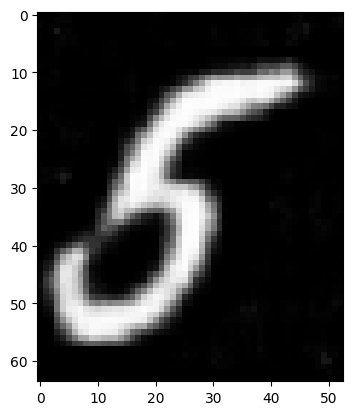

In [59]:
# test the function
plt.imshow(generate_number(5));

In [60]:
def generate_numbers(num):
    # Convert the input number to a string
    num_str = str(int(num))

    # Initialize an empty numpy array to store the generated image
    numbers_image = np.zeros((64, 1, 3))

    # Generate an image for each digit in the input number and concatenate them horizontally
    for i in range(len(num_str)):
        numbers_image = np.concatenate((numbers_image, generate_number(num_str[i])), axis=1)
    
    # Remove the first column (which is all zeros) and return the resulting image
    return numbers_image[:, 1:, :]

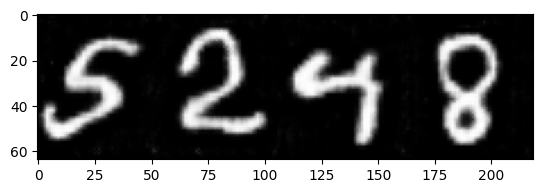

In [62]:
# test the function
plt.imshow(generate_numbers(5248));

# Making the Gradio app

In [63]:
# Import the Gradio library
import gradio as gr

# Create a Gradio input component for a positive integer
inp = gr.Number(value=0, minimum=0, label="Enter a positive integer")

# Create a Gradio output component for an image
out = gr.Image(shape=(250, None), image_mode="L", show_download_button=True)

# Create a Gradio interface with the generate_numbers function as the processing function
# The input is the inp component and the output is the out component
# The examples are provided to show sample inputs to the user
# The allow_flagging parameter is set to "never" to disable flagging of examples
demo = gr.Interface(fn=generate_numbers, inputs=inp, outputs=out, examples=[[14], [253], [823], [982140]], allow_flagging="never")

# Launch the Gradio interface
demo.launch()

Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.
